# Objective: To assign patients beds effectively to minimize the waiting time

In [3]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.manual_seed(0)

# Steps:
1. Split the State in 2 parts S_in and S_out depending upon the threshold (U). 
2. S_in = data[<=U], S_out = data[>U] 
3. Initialize Lyapunov function
4. Baseline model
5. Exploration: Initiate model and estimate Lyapunov function 
6. Exploitation: Policy from Exploration will be used for S_in and for S_out a stable policy will be used.
7. Estimate model stability using Lyapunov function 

# Dummy dataset with some main features

In [4]:
# Generating random datetime values within a certain range
from datetime import datetime, timedelta
import random

N_obs = 2000


start_datetime = datetime(2023, 1, 1, 0, 0, 0)
end_datetime = datetime(2023, 1, 10, 23, 59, 59)


random_date_times = [
    start_datetime + timedelta(
        seconds=random.randint(0, int((end_datetime - start_datetime).total_seconds()))
    )
    for _ in range(N_obs)
]


Create a formula for processing time after bed is assigned.
Apply FCFS accordingly


In [5]:
Ndoctors = 25
MaxAclvl = 4
Nbeds = 35

state = pd.DataFrame({
    "Available Beds": np.random.randint(1, Nbeds+1, N_obs),
    # "Available Doctors": np.random.randint(1, Ndoctors+1, N_obs)

})

patients = pd.DataFrame(
    {
    "ArrivalTime": random_date_times,
    "Acuity_Lvl": np.random.randint(1, MaxAclvl+1, N_obs),
    "Age": [random.randint(1, 100) for _ in range(N_obs)],
    "Gender": [random.choice(["Male", "Female"]) for _ in range(N_obs)],
    }
)
patients['year'], patients["month"], patients['day'], patients['hour'], patients['minute'], patients['second'] = \
        patients["ArrivalTime"].dt.year, patients["ArrivalTime"].dt.month, patients["ArrivalTime"].dt.day, patients["ArrivalTime"].dt.hour, patients["ArrivalTime"].dt.minute, patients["ArrivalTime"].dt.second

acuity_weights = {
        1: 0.5,
        2: 0.75,
        3: 1.0,
        4: 1.25,
        5: 1.5,
    }

def calculate_end_time(row):
    acuity_weight = acuity_weights[row["Acuity_Lvl"]]
    occupancy_time = pd.Timedelta(hours=row["Acuity_Lvl"] * acuity_weight)
    return row["ArrivalTime"] + occupancy_time

# Calculate and add the end time
patients["OccupancyTime"] = patients.apply(calculate_end_time, axis=1)


# patients.sort_values(by="ArrivalTime")
patients.sample(5)

,ArrivalTime,Acuity_Lvl,Age,Gender,year,month,day,hour,minute,second,OccupancyTime
510,2023-01-09 21:50:00,4,12,Female,2023,1,9,21,50,0,2023-01-10 02:50:00
1634,2023-01-07 15:32:58,2,41,Male,2023,1,7,15,32,58,2023-01-07 17:02:58
1801,2023-01-10 10:31:37,2,27,Male,2023,1,10,10,31,37,2023-01-10 12:01:37
253,2023-01-07 03:31:19,2,85,Female,2023,1,7,3,31,19,2023-01-07 05:01:19
1924,2023-01-09 11:52:06,2,92,Male,2023,1,9,11,52,6,2023-01-09 13:22:06


# Dispacthing rules (Baseline policies)

## First Come First Serve

Scheduling acc: ArrivalTime
Queue length: 15
Batch Size: 30
Average Wait Time: 5901.933820833333
--------------------------------------------------------------------------------
Scheduling acc: ['Acuity_Lvl', 'ArrivalTime']
Queue length: 15
Batch Size: 30
Average Wait Time: 3997.7542125


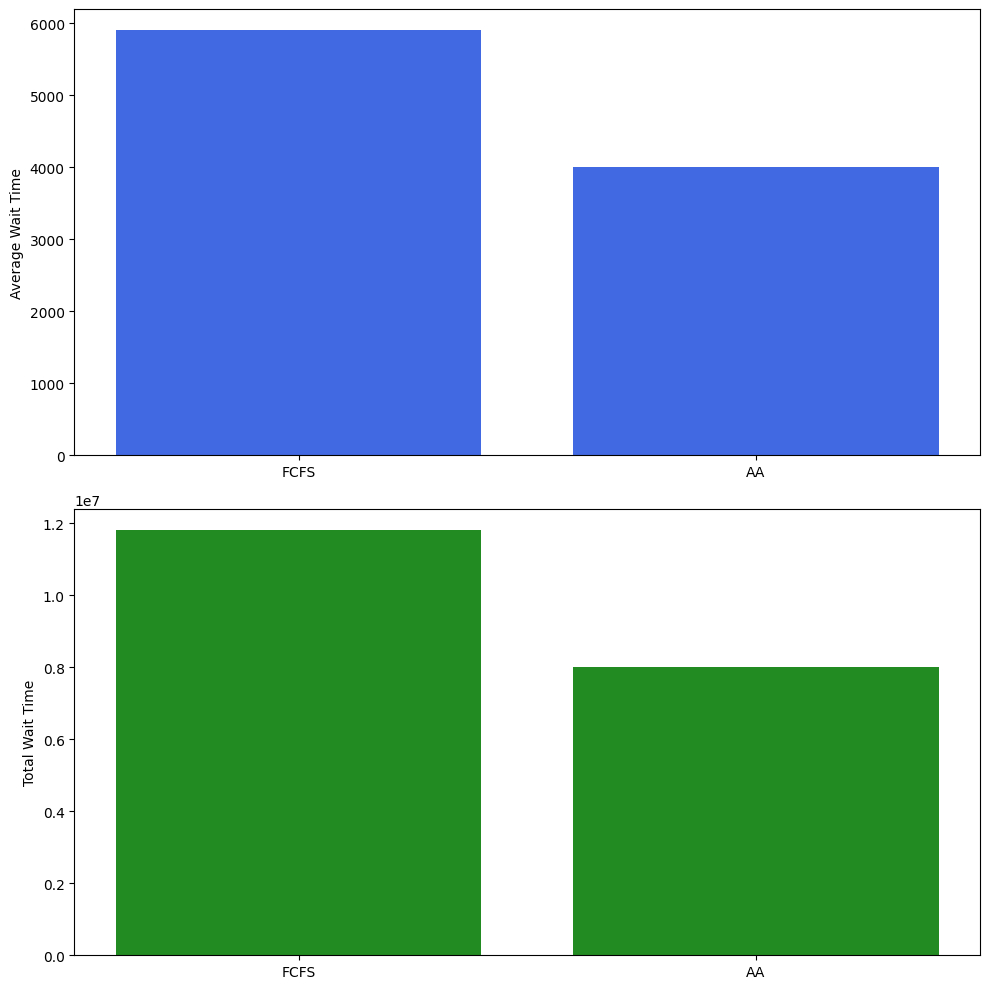

In [6]:
mean_minutes_acuity_1 = patients[patients['Acuity_Lvl'] == 1]['OccupancyTime'].dt.minute.mean()
mean_minutes_acuity_2 = patients[patients['Acuity_Lvl'] == 2]['OccupancyTime'].dt.minute.mean()

def scheduler(df, criterion="ArrivalTime", BATCH_SIZE=20, NBeds=10):
    NBeds = NBeds
    BATCH_SIZE = BATCH_SIZE
    print("Scheduling acc:", criterion)
    org = df.copy()
    if "Age" in criterion or "Acuity_Lvl" in criterion:
        queue = df.sort_values(by=criterion[:-1], ascending=False).iloc[:NBeds].copy()   
    
    queue = df.sort_values(by=criterion).iloc[:NBeds].copy()
    df = df.iloc[NBeds:]

    print("Queue length:", queue.shape[0])
    print("Batch Size:", BATCH_SIZE)

    wait_times = [0 for i in range(NBeds)]
    penalty_1, penalty_2 = 0, 0

    for start in range(0, len(patients), BATCH_SIZE):
        end = min(start + BATCH_SIZE, len(patients))
        batch = df[start:end].copy()
        if "Age" in criterion or "Acuity_Lvl" in criterion:
            batch = batch.sort_values(criterion[:-1], ascending=False)
        batch = batch.sort_values(criterion)
        while not batch.empty:
            entry_patient = batch.iloc[0]
            arrival_time = entry_patient["ArrivalTime"]
            acuity_level = entry_patient["Acuity_Lvl"]
            
            wait_time = acuity_weights[acuity_level] * (abs(arrival_time - queue.iloc[0]["OccupancyTime"])).total_seconds() / 60
            if wait_time > (60 + mean_minutes_acuity_1) and acuity_level == 1: # Add occupancy avg time for the acuity lvl
                penalty_1 += 1
            elif wait_time > (180 + mean_minutes_acuity_2) and acuity_level == 2:
                penalty_2 += 1
            wait_times.append(wait_time)
            
            queue = queue.iloc[1:].copy()  # Remove the front patient from the queue
            queue = pd.concat([queue, entry_patient.to_frame().T], ignore_index=True, sort=False)
            batch = batch.iloc[1:].copy()  # Remove the processed patient from the batch
    org['wait_times'] = wait_times
    Percent_penalty_1 = abs(penalty_1 - len(patients[patients['Acuity_Lvl'] == 1]))/100
    Percent_penalty_2 = abs(penalty_2 - len(patients[patients['Acuity_Lvl'] == 2]))/100

    return np.mean(wait_times), np.sum(wait_times), np.max(wait_times), np.min(wait_times), df, Percent_penalty_1, Percent_penalty_2
avg_fcfs, total_fcfs, maximum_fcfs, minimum_fcfs, fcfs_df, per_penalty1_fcfs, per_penalty2_fcfs = scheduler(patients, "ArrivalTime", BATCH_SIZE=30, NBeds=15)
print("Average Wait Time:", avg_fcfs)
# print("Sum Wait Time:", total_fcfs)
# print("Maximum Wait Time:", maximum_fcfs)
# print("Minimum Wait Time:", minimum_fcfs)

print("----"*20)
avg_aat, total_aat, maximum_aat, minimum_aat, df_aat, per_penalty1_aat, per_penalty2_aat = scheduler(patients, ["Acuity_Lvl", "ArrivalTime"], BATCH_SIZE=30, NBeds=15)
print("Average Wait Time:", avg_aat)
# print("Sum Wait Time:", total_aat)
# print("Maximum Wait Time:", maximum_aat)
# print("Minimum Wait Time:", minimum_aat)

# print("----"*20)
# avg_aaat, total_aaat, maximum_aaat, minimum_aaat, df_aaat, per_penalty1_aaat, per_penalty2_aaat = scheduler(patients, ["Acuity_Lvl", "Age", "ArrivalTime"], BATCH_SIZE=30, NBeds=15)
# print("Average Wait Time:", avg_aaat)
# print("Sum Wait Time:", total_aaat)
# print("Maximum Wait Time:", maximum_aaat)
# print("Minimum Wait Time:", minimum_aaat)


import pandas as pd

# Create DataFrames for each scheduling method with penalties
data_fcfs = {
    "Method": "FCFS",
    "Weighted Avg Waiting Time": avg_fcfs,
    # "Total Wait Time": total_fcfs,
    # "Maximum Wait Time": maximum_fcfs,
    # "Minimum Wait Time": minimum_fcfs,
    # "Penalty 1": per_penalty1_fcfs,
    # "Penalty 2": per_penalty2_fcfs,
    "Penalty": (per_penalty1_fcfs+per_penalty2_fcfs)/2
}

data_aat = {
    "Method": "AA",
    "Weighted Avg Waiting Time": avg_aat,
    # "Total Wait Time": total_aat,
    # "Maximum Wait Time": maximum_aat,
    # "Minimum Wait Time": minimum_aat,
    # "Penalty 1": per_penalty1_aat,
    # "Penalty 2": per_penalty2_aat,
    "Penalty": (per_penalty1_aat+per_penalty2_aat)/2
}

# data_aaat = {
#     "Method": "Acuity + Age + ArrivalTime",
#     "Average Wait Time": avg_aaat,
#     "Total Wait Time": total_aaat,
#     "Maximum Wait Time": maximum_aaat,
#     "Minimum Wait Time": minimum_aaat,
#     "Penalty 1": per_penalty1_aaat,
#     "Penalty 2": per_penalty2_aaat,
# }

df_fcfs = pd.DataFrame(data_fcfs, index=[0])
df_aat = pd.DataFrame(data_aat, index=[0])
# df_aaat = pd.DataFrame(data_aaat, index=[0])

# Concatenate the DataFrames
result_df = pd.concat([df_fcfs, df_aat], ignore_index=True)

methods = ["FCFS", "AA"]
average_wait_times = [avg_fcfs, avg_aat]
total_wait_times = [total_fcfs, total_aat]
maximum_wait_times = [maximum_fcfs, maximum_aat]
minimum_wait_times = [minimum_fcfs, minimum_aat]

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Create comparison plots
ax1.bar(methods, average_wait_times, color='royalblue')
ax1.set_ylabel('Average Wait Time')

ax2.bar(methods, total_wait_times, color='forestgreen')
ax2.set_ylabel('Total Wait Time')

# Save or show the plots
plt.tight_layout()
plt.show()

In [7]:
result_df

,Method,Weighted Avg Waiting Time,Penalty
0,FCFS,5901.933821,0.03
1,AA,3997.754212,0.20


In [8]:
from sklearn.preprocessing import LabelEncoder

for col in ["Gender"]:
    patients[col] = LabelEncoder().fit_transform(patients[col])

data = patients.drop(["ArrivalTime", "OccupancyTime"], axis=1)
data_cols = data.columns
data = torch.tensor(data.to_numpy(), dtype=torch.float32)

#### Handling Unboundedness using U (Size) thresholding

In [9]:
U = int(data.shape[0] * 0.6)
S_in = data[:U]
S_out = data[U:-1]
X_test = data[-1]

# Deep Q Learning model

### Agent

# Pretraining model inference

In [10]:
patients[patients.ArrivalTime == patients.ArrivalTime.min()]
patients

,ArrivalTime,Acuity_Lvl,Age,Gender,year,month,day,hour,minute,second,OccupancyTime
0,2023-01-09 12:56:45,1,26,0,2023,1,9,12,56,45,2023-01-09 13:26:45
1,2023-01-07 11:35:58,2,62,0,2023,1,7,11,35,58,2023-01-07 13:05:58
2,2023-01-02 04:18:58,4,23,1,2023,1,2,4,18,58,2023-01-02 09:18:58
3,2023-01-10 00:59:42,2,97,0,2023,1,10,0,59,42,2023-01-10 02:29:42
4,2023-01-02 18:28:45,4,23,1,2023,1,2,18,28,45,2023-01-02 23:28:45
...,...,...,...,...,...,...,...,...,...,...,...
1995,2023-01-03 01:13:14,2,21,0,2023,1,3,1,13,14,2023-01-03 02:43:14
1996,2023-01-06 00:40:29,1,16,1,2023,1,6,0,40,29,2023-01-06 01:10:29
1997,2023-01-06 16:21:29,4,56,0,2023,1,6,16,21,29,2023-01-06 21:21:29
1998,2023-01-07 16:00:54,4,61,1,2023,1,7,16,0,54,2023-01-07 21:00:54


### Deep Reinforcement Learning module

In [11]:
pd.DataFrame(S_in, columns = [patients.columns[1:-1]])

,Acuity_Lvl,Age,Gender,year,month,day,hour,minute,second
0,1.0,26.0,0.0,2023.0,1.0,9.0,12.0,56.0,45.0
1,2.0,62.0,0.0,2023.0,1.0,7.0,11.0,35.0,58.0
2,4.0,23.0,1.0,2023.0,1.0,2.0,4.0,18.0,58.0
3,2.0,97.0,0.0,2023.0,1.0,10.0,0.0,59.0,42.0
4,4.0,23.0,1.0,2023.0,1.0,2.0,18.0,28.0,45.0
...,...,...,...,...,...,...,...,...,...
1195,4.0,46.0,1.0,2023.0,1.0,2.0,5.0,5.0,2.0
1196,3.0,78.0,1.0,2023.0,1.0,8.0,4.0,5.0,16.0
1197,4.0,39.0,1.0,2023.0,1.0,9.0,14.0,26.0,49.0
1198,1.0,27.0,1.0,2023.0,1.0,7.0,3.0,58.0,50.0


In [12]:
import random
import numpy as np
import torch
from tqdm import trange
import torch.nn as nn
import torch.optim as optim
import gym

from tqdm.autonotebook import tqdm

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, action_dim),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.network(x)

class DQNAgent:
    def __init__(self, state_dim, action_dim, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.01, gamma=0.99, learning_rate=0.001):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.gamma = gamma
        self.q_network = DQN(state_dim, action_dim).to(device)
        self.target_network = DQN(state_dim, action_dim).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.AdamW(self.q_network.parameters(), lr=learning_rate)
        self.loss_fn = nn.HuberLoss()

    def select_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.randint(0, 1)
        else:
            with torch.no_grad():
                q_values = self.q_network(state)
                return q_values.argmax().item()

    def train(self, state, action, next_state, reward, done):
        q_values = self.q_network(state.to(device))
        next_q_values = self.target_network(next_state.to(device))
        target = q_values.clone()
        if done:
            target[0][action] = reward
        else:
            target[0][action] = reward + self.gamma * next_q_values.max().item()

        loss = self.loss_fn(q_values, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.epsilon_decay

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())


class PatientSchedulingEnv(gym.Env):
    def __init__(self, dataset):
        super(PatientSchedulingEnv, self).__init__()
        self.dataset = dataset
        self.state_dim = dataset.shape[0] - 1  # Exclude the 'Action' column
        self.action_dim = 2
        self.current_index = 0

    def reset(self):
        self.current_index = 0
        return self.get_state()

    def step(self, action):
        if action not in [0, 1]:
            raise ValueError("Invalid action")

        next_state = self.get_state()
        reward = self.calculate_reward(action)
        done = self.current_index >= len(self.dataset) - 1
        info = {}

        self.current_index += 1

        return next_state, reward, done, info

    def get_state(self):
        return self.dataset[self.current_index, :-1]  # Exclude the 'Action' column

    def calculate_reward(self, action):
        acuity_level = self.dataset[self.current_index, 0]
        age = self.dataset[self.current_index, 1]
        gender = self.dataset[self.current_index, 2]
        if action == 0: # Modifications needed
            reward = (acuity_level * 0.8 + age * 0.15 + gender * 0.05)
        else:
            reward = (-acuity_level * 0.8 + age * 0.15 + gender * 0.05)

        return reward

state_dim = S_in.shape[1] - 1
action_dim = 2
device = "cuda" if torch.cuda.is_available() else "cpu"
agent = DQNAgent(state_dim, action_dim)
env = PatientSchedulingEnv(S_in )
num_episodes = 500
rewards = []

In [13]:

with trange(num_episodes, desc='Episodes', position=0, leave=True) as progress_bar:
    for episode in progress_bar:
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            state_tensor = state.unsqueeze(0).clone().detach()
            action = agent.select_action(state_tensor.to(device))
            next_state, reward, done, _ = env.step(action)
            agent.train(state_tensor, action, next_state.clone().detach().unsqueeze(0), reward, done)
            state = next_state
            total_reward += reward

        agent.update_target_network()

        rewards.append(total_reward)
        progress_bar.set_postfix(TotalReward=total_reward.item())
    

plt.plot(rewards)
plt.show()

Episodes:   4%|▍         | 20/500 [00:45<18:12,  2.28s/it, TotalReward=6.68e+3]


KeyboardInterrupt: 

In [17]:
min(rewards), max(rewards)

(tensor(10970.3936), tensor(11384.7969))

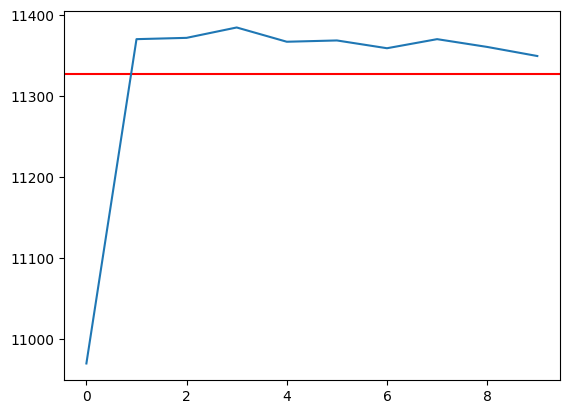

In [18]:
# Checking the last 300 rewards
plt.axhline(np.mean(rewards), color='r', linestyle='-')
plt.plot(rewards[-300:]);

# New approach

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from collections import deque

# Define the Q-network
class QNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the replay memory
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return (
            torch.cat(state),
            torch.tensor(action),
            torch.tensor(reward, dtype=torch.float32),
            torch.cat(next_state),
            torch.tensor(done, dtype=torch.float32)
        )
# Define the DQN agent
class DQNAgent:
    def __init__(self, input_size, output_size, gamma=0.95, epsilon=1.0, epsilon_decay=0.80, epsilon_min=0.01):
        self.q_network = QNetwork(input_size, output_size)
        self.target_network = QNetwork(input_size, output_size)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=0.001)
        self.memory = ReplayMemory(capacity=1000)
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

    def select_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(0, 2)  # Assuming two actions (0 and 1)
        else:
            with torch.no_grad():
                q_values = self.q_network(state)
                return int(torch.argmax(q_values).item())

    def train(self, batch_size):
        if len(self.memory.memory) < batch_size:
            return

        state, action, reward, next_state, done = self.memory.sample(batch_size)

        q_values = self.q_network(state).gather(1, action.unsqueeze(1))
        next_q_values = self.target_network(next_state).max(1)[0].detach()

        target = reward + (1 - done) * self.gamma * next_q_values
        loss = F.smooth_l1_loss(q_values, target.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

# Assuming you have a dataset named 'your_dataset.csv'
data = pd.DataFrame(S_in, columns = [patients.columns[1:-1]])

# Assuming 'Acuity_Lvl' is one of the features you want to consider
state_size = len(data.columns)
output_size = 2  # Assuming two actions (0 and 1)

# Initialize the DQN agent
agent = DQNAgent(input_size=state_size, output_size=output_size)

# Training loop
num_episodes = 1000
batch_size = 64

for episode in range(num_episodes):
    state = torch.tensor(data.iloc[0].values, dtype=torch.float32).unsqueeze(0)  # Initial state
    total_reward = 0

    
    for t in range(len(data) - 1):  # Iterate up to len(data) - 1
        action = agent.select_action(state)
        next_state = torch.tensor(data.iloc[t + 1].values, dtype=torch.float32).unsqueeze(0)  # Assuming sequential data
        reward = data.iloc[t]['Acuity_Lvl']  # You can customize the reward calculation based on waiting time and acuity level
        done = False

        agent.memory.push((state, torch.tensor(action), torch.tensor(reward), next_state, torch.tensor(done, dtype=torch.float32)))
        agent.train(batch_size)
        agent.update_target_network()

        total_reward += reward
        state = next_state

    # Decay epsilon
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay

    print(f"Episode {episode + 1}, Total Reward: {total_reward}")


Episode 52, Total Reward: 3028.0
Episode 53, Total Reward: 3028.0
Episode 54, Total Reward: 3028.0
Episode 55, Total Reward: 3028.0
Episode 56, Total Reward: 3028.0
Episode 57, Total Reward: 3028.0
Episode 58, Total Reward: 3028.0
Episode 59, Total Reward: 3028.0
Episode 60, Total Reward: 3028.0
Episode 61, Total Reward: 3028.0
Episode 62, Total Reward: 3028.0
Episode 63, Total Reward: 3028.0
Episode 64, Total Reward: 3028.0
Episode 65, Total Reward: 3028.0
Episode 66, Total Reward: 3028.0
Episode 67, Total Reward: 3028.0
Episode 68, Total Reward: 3028.0
Episode 69, Total Reward: 3028.0
Episode 70, Total Reward: 3028.0
Episode 71, Total Reward: 3028.0
Episode 72, Total Reward: 3028.0
Episode 73, Total Reward: 3028.0
Episode 74, Total Reward: 3028.0
Episode 75, Total Reward: 3028.0
Episode 76, Total Reward: 3028.0
Episode 77, Total Reward: 3028.0
Episode 78, Total Reward: 3028.0
Episode 79, Total Reward: 3028.0
Episode 80, Total Reward: 3028.0
Episode 81, Total Reward: 3028.0
Episode 82

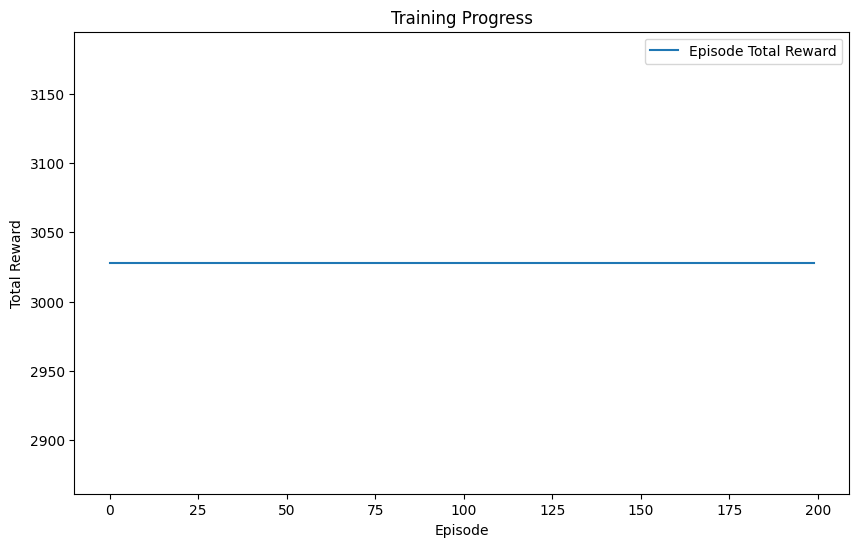

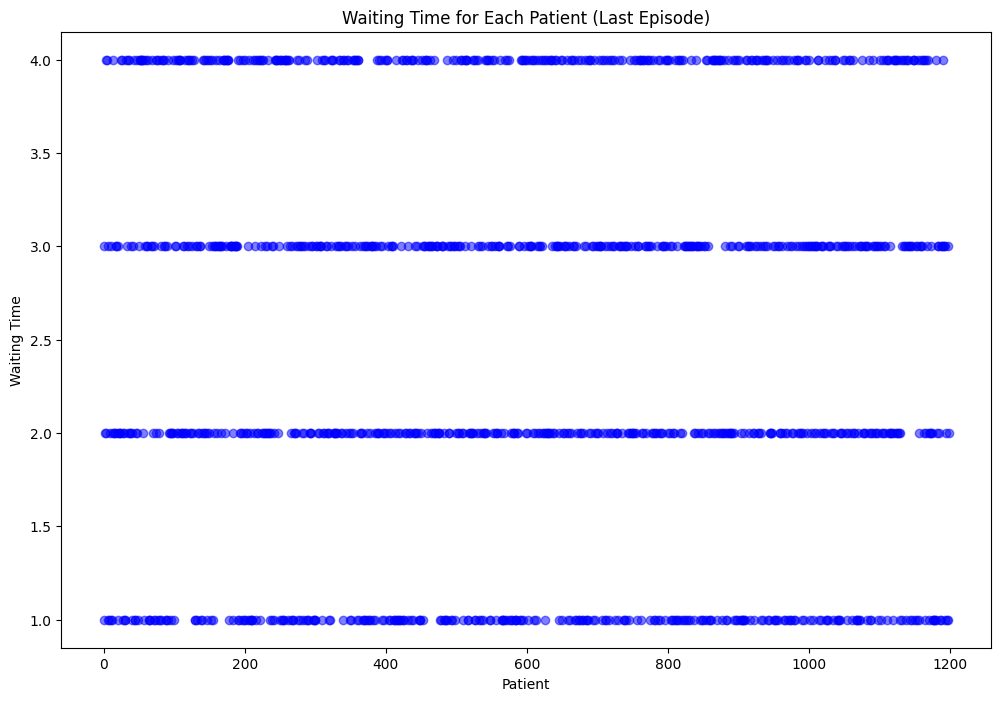

In [44]:
import matplotlib.pyplot as plt

num_episodes = 200
batch_size = 64

episode_rewards = []
waiting_times = []

for episode in range(num_episodes):
    state = torch.tensor(data.iloc[0].values, dtype=torch.float32).unsqueeze(0)  # Initial state
    total_reward = 0
    episode_waiting_times = []

    # Episode simulation loop
    for t in range(len(data) - 1):  # Iterate up to len(data) - 1
        # Agent selects an action based on the current state
        action = agent.select_action(state)

        # Assuming sequential data, get the next state
        next_state = torch.tensor(data.iloc[t + 1].values, dtype=torch.float32).unsqueeze(0)

        # Reward for the current step (you can customize the reward calculation)
        reward = data.iloc[t]['Acuity_Lvl']

        # Check if it's the last step of the episode
        done = False

        # Store waiting time for the current patient
        episode_waiting_times.append(reward)

        # Store the experience in the replay memory
        agent.memory.push((state, torch.tensor(action), torch.tensor(reward), next_state, torch.tensor(done, dtype=torch.float32)))

        # Train the agent
        agent.train(batch_size)

        # Update the target network
        agent.update_target_network()

        # Accumulate the total reward
        total_reward += reward

        # Move to the next state
        state = next_state


    # Decay epsilon for exploration-exploitation trade-off
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay

    # Store episode statistics
    episode_rewards.append(total_reward)
    waiting_times.append(episode_waiting_times)

    # Print episode results
    print(f"Episode {episode + 1}, Total Reward: {total_reward}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(episode_rewards, label='Episode Total Reward')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Progress')
plt.legend()
plt.show()

# Plotting waiting time for each patient in the last episode
plt.figure(figsize=(12, 8))
for i, waiting_time in enumerate(waiting_times[-1]):
    plt.scatter([i], [waiting_time], color='blue', alpha=0.5)

plt.xlabel('Patient')
plt.ylabel('Waiting Time')
plt.title('Waiting Time for Each Patient (Last Episode)')
plt.show()
